# Bed Analysis by Z-Probe

This notebook calculate the gcode required to probe the Trium delta printer. In principle, the code can be adapted to any delta printer by appropriate changes to the contants.

The sample points are calculated on a regular grid according to the user-specified sampling density, plus a series of additional points near the towers and in the centre of the bed.  The points are carefully selected to present three points on lines partway to the tower. These three points correspond to the points on a smaller four-point test.  The idea is to use the detailed sampling less often and then use the four-point sample test for regular levelling.

## Repetier Logfile

It is somewhat of a mission to do a long multi-sample mesh probe with Repetier. For a few samples the log display on the screen is sufficiently large to capture all data.  However, for the 84-sample probe file created in here, the screen log area refreshes and loses some of the information. To capture the full log, you must use the Repetier log file on disk.  The procedure is as follows:

- Switch on the disk log file capture (by default is is off) using the Config/Preferences menu setting.
- Close Repetier to make the change effective.
- Execute the bed probing with the 84 sample file.
- Close Repetier again to force the completion of the log file writing to disk.
- Open the log file from disk in the directory `%USER%\AppData\Local\RepetierHost` ( you can change the location in the preferences setting.
- Cut the portion containing the information.


## Input data

The settings shown below were carefully tuned to achieve the following objectives:
- Keep the PWM fans clear of the Y and Z towers when probing.
- Keep the probe on the bed.
- Include the centre as a valid sample point.
- Include three sample points on a line between the centre and a tower, near a tower, such that the point can be compared with a simpler sampling procedure used for bed levelling.
- Give a reasonable sampling density at regular intervals.
- Do regular G28 homing commands. 



In [234]:
# to prepare and load constants

import numpy as np
from scipy.interpolate import interp2d
import scipy.linalg
import scipy.ndimage
import pyradi.ryplot as ryplot
import pandas as pd
import sys
import os
import os.path
import fnmatch
from sympy import Plane, Point3D,N,sympify,Line3D
from sympy.matrices import Matrix
import math

pd.set_option('precision', 3)

%matplotlib inline


np.set_printoptions(linewidth=120)
pd.set_option('display.width', 120)

bedRadius = 110. 
towerRadius = 180. # centre to belts
towerClearance = 70. # distance nozzle to outmost fan part
ang = np.pi * 30. / 180.
xtowerpos = (-towerRadius * np.cos(ang),-towerRadius * np.sin(ang))
xOpposite = 270. # maximum distance from X tower
probeRadius = 104. # don't probe near edges
samplintx = 18.125 # sample interval in mm
samplinty = 22 # sample interval in mm
maxsize = 2.5 *  bedRadius  # number of points spread over this distance
xoffset = -33.5 # probe offset from nozzle
yoffset = -5. # probe offset from nozzle
numg28 = 2 # number of samples between g28 
numg30=5 # number of probes per one position
# control plotting 
showMarlinSamples = True


In [235]:
# to create the grid
x = np.arange(0,maxsize,samplintx)
x = np.sort(np.append(x,-x[1:]))
y = np.arange(0,maxsize,samplinty)
y = np.sort(np.append(y,-y[1:]))

# xx,yy are the required probe positions
xx,yy = np.meshgrid(x,y)
radius = np.sqrt(xx*xx+yy*yy)
# xn, yn are the nozzle positions corresponding to the above probe positions
xn = xx - xoffset
yn = yy - yoffset

# p = ryplot.Plotter(1,1,1,figsize=(8,7));
# p.meshContour(1,xx,yy,radius,contLabel=True,cbarshow=True);
# print(np.unique(xx))
# print(np.unique(yy))



The code below starts with a full and large grid of sampling points and then eliminates the illegal sample points.  Towards the Y tower some sampling points have to be dropped to prevent the fan from moving in into the Y-tower belt.

The gcode file created with this data set creates 84 samples over most of the bed.

In [239]:
# to eliminate the 'illegal' points
# Y tower, cutout around the tower by a sloping line, X limit and Y limit
coffset =  - (towerRadius-towerClearance) / np.tan(np.pi * 30. / 180.) 
slope = 2.
maskYs = yy >  slope*xx+coffset
maskYx = xx < 75.
maskYy = yy > -100.
maskY =  np.logical_and( maskYs, np.logical_and(maskYy,maskYx))
# Z tower
maskZ = yy  <  towerRadius-towerClearance
# X opposite extreme: movement not very accurate beyond this
maskXe = np.sqrt((xx-xtowerpos[0])**2 + (yy-xtowerpos[1])**2) < xOpposite

# probe area within the head
maskB = radius <= probeRadius

# start with all possible points, then remove points below
valid = np.ones((xx.shape))
valid =  np.logical_and(valid,maskY)
valid =  np.logical_and(valid, maskZ) 
valid = np.logical_and(valid, maskXe)
valid = np.logical_and(valid, maskB)

numSamples = np.sum(valid.flatten())

# create circles for plotting below
rang = np.linspace(0,2*np.pi,360)
xb = bedRadius * np.sin(rang)
yb = bedRadius * np.cos(rang)
xt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.sin(rang)
yt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.cos(rang)

print('Number of samples is {}'.format(numSamples))
print('unique probe x values:\n{}'.format(np.sort(np.unique(xx[valid]))))
print('unique probe y values:\n{}'.format(np.sort(np.unique(yy[valid]))))
print('unique nozzle x values:\n{}'.format(np.sort(np.unique(xn[valid]))))
print('unique nozzle y values:\n{}'.format(np.sort(np.unique(yn[valid]))))


Number of samples is 78
unique probe x values:
[-90.625 -72.5   -54.375 -36.25  -18.125   0.     18.125  36.25   54.375  72.5  ]
unique probe y values:
[-88. -66. -44. -22.   0.  22.  44.  66.  88.]
unique nozzle x values:
[ -57.125  -39.     -20.875   -2.75    15.375   33.5     51.625   69.75    87.875  106.   ]
unique nozzle y values:
[-83. -61. -39. -17.   5.  27.  49.  71.  93.]


The following set of plots show the individual limits on the positioning in the gcode script.  The Y tower limit is the or of the slant, x and y limits because each of the limits individually are too severe.

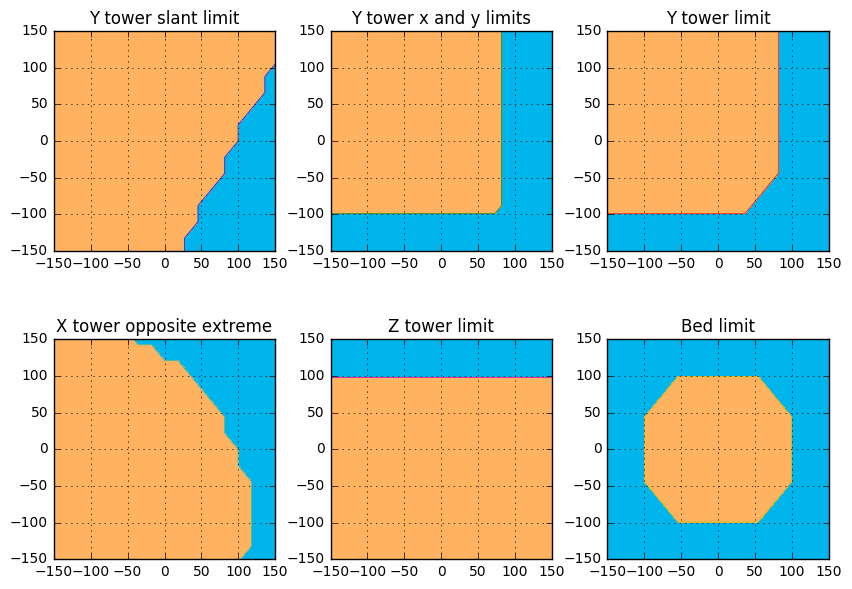

In [237]:
# to plot individual limits
q = ryplot.Plotter(1,2,3,figsize=(10,7));
q.meshContour(1,xx,yy,maskYs,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower slant limit');
q.meshContour(2,xx,yy,np.logical_and(maskYy,maskYx),contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower x and y limits');
q.meshContour(3,xx,yy,maskY,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower limit');
q.meshContour(4,xx,yy,maskXe,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='X tower opposite extreme');
q.meshContour(5,xx,yy,maskZ,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Z tower limit');
q.meshContour(6,xx,yy,maskB,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Bed limit');


The following graphs show the final result, in probe position and nozzle position.  The gcode file is written using the nozzle position data.

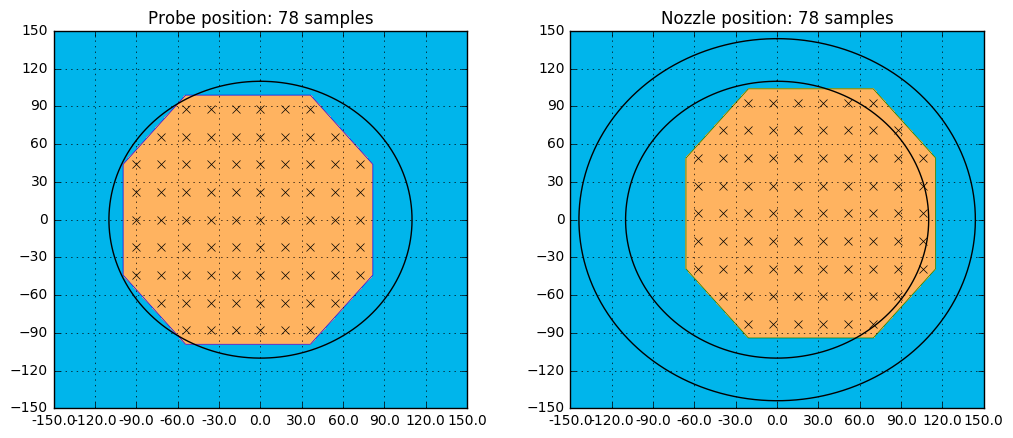

In [241]:
# to plot sample points
p = ryplot.Plotter(2,1,2,figsize=(12,5));

p.meshContour(1,xx,yy,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Probe position: {} samples'.format(numSamples));
p.plot(1,xb,yb,plotCol=['k']);
p.plot(1,xx[valid],yy[valid],plotCol=['k'],markers=['x'],linestyle='');

p.meshContour(2,xx-xoffset,yy-yoffset,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Nozzle position: {} samples'.format(numSamples));
p.plot(2,xb,yb,plotCol=['k']);
p.plot(2,xx[valid]-xoffset,yy[valid]-yoffset,plotCol=['k'],markers=['x'],linestyle='');
p.plot(2,xt,yt,plotCol=['k']);

Finally, the gcode file is written.

It was found that doing only one G28 homing at the start of the procedure is not sufficient, it leads to very large errors towards the end of the run (0.4 mm).  It takes a long time to G28 at every sample, but the present arrangement of G28 at every second sample appears to provide sufficient accuracy (but the procedure does takes a long time to do the frequent G28s).


In [242]:
# to write the gcode file
lst = []
for ix in range(0,xn.shape[0]):
    for iy in range(0,xn.shape[1]):
        if valid[ix,iy]:
            lst.append([xn[ix,iy],yn[ix,iy],xx[ix,iy],yy[ix,iy]])


df = pd.DataFrame(np.asarray(lst),columns=['xn','yn','xx','yy'])

header = """
;  probe the Trium bed in {} positions, {} times at each point
M119 ; print a separator in the log file
M105 ; get temperatures
G21  ; set units to mm
G90  ; absolute positioning
G28  ; home: reset coord sys by reading MAX endstops\n
""".format(df.shape[0],numg30)

footer = """
G28 ; home: reset coord sys by reading MAX endstops\n
"""

#note: we write nozzle position out here, not probe position
filename = 'g30-zprobe-{}-{}.gcode'.format(df.shape[0],numg30)
print('Writing {}'.format(filename))
with open(filename,'w') as fo:
    fo.write(header)
    for ie,idx in enumerate(df.index.values):
        strln = 'G0 X{:.3f} Y{:.3f} Z10 F3000\n'.format(df.ix[idx]['xn'],df.ix[idx]['yn'])
        fo.write(strln)
        for i in range(0,numg30):
            fo.write('G30\n')
        if not ie % numg28:
            fo.write('G28  ; home: reset coord sys by reading MAX endstops\n')
            
    fo.write(footer)

Writing g30-zprobe-78-5.gcode


After scanning the bed with the gcode file, the results are extracted from the Repetier log file (on disk) and placed in a new text file, read in and plotted.  The function below plots the results from the file.  For each position, the average is taken for all the samples at the specific point.

In [7]:
################################################################################
# label the towers
def label_tower(row):
    # near X tower
    if np.abs(row['x']+72.5) < 2. and np.abs(row['y']+44.0) < 2.:
        return 'X'
    # near Y tower
    if np.abs(row['x']-72.5) < 2. and np.abs(row['y']+44.0) < 2.:
        return 'Y'
    # near Z tower
    if np.abs(row['x']) < 2. and np.abs(row['y']-88.0) < 2.:
      return 'Z'
    if np.abs(row['x']) < 2. and np.abs(row['y']) < 2.:
      return 'C'
    return ''


In [8]:
##
def readInputFile(filename):
    tdone = False
    validlines = []
    bedtemp = ''
    
    with open(filename,'r') as fin:
        lines = fin.readlines()
        for line in lines:
            line = line.strip()
            if len(line)>3:
                if '>' in line[0] or '<' in line[0]:
                    line = line[2:]
                lstl = line.split(' ')
                # only use lines with Bed X: in them for dataframe
                if 'Bed X:' in line:
                    # remove unwanted clutter, keep only x,y,z
                    validlines.append([float(lstl[i]) for i in [4,6,8]])
                # if temperature lines, get values
                if not tdone and 'ok' in line and 'T:' in line and 'B:' in line:
                    mtime = lstl[0]
                    bedtemp = float(lstl[5].split(':')[1])
                    nozztemp = float(lstl[3].split(':')[1])
                    tdone = True
                if 'M665' in line:
                    drad = lstl[6][1:]
                if 'M851' in line:
                    zProbeOffset = float(lstl[5][1:])
                    
        # make pandas dataframe
        df = pd.DataFrame(validlines,columns=['x','y','z'])
        return df,drad,zProbeOffset,bedtemp, mtime,nozztemp
    

In [82]:
def getBestFitPlane(dfp,dfr,lift=0.0):
    # calculate a best-fit plane through the data points
    # set up grid
    xUni = np.sort(dfr['x'].unique())
    yUni = np.sort(dfr['y'].unique())
    xUm,yUm = np.meshgrid(xUni,yUni)
    # https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6#file-curve_fitting-py
    A = np.c_[dfr['x'],dfr['y'],np.ones(dfr['y'].shape)]
    bfcoeff,_,_,_ = scipy.linalg.lstsq(A, dfr['z'])    # coefficients
    # evaluate best-fit-plane on grid
    bfplane = bfcoeff[0] * xUm + bfcoeff[1] * yUm  + bfcoeff[2]
    # substract the best fit plane to get 'corrected bed'
    # actually we should have rotated, this subtraction assumes small rotation angles
    bfcorrected = dfp.values - bfplane 
#     bfcorrected -= np.nanmean(bfcorrected.flatten())
    bfcorrected -= np.nanmax(bfcorrected.flatten())
    bfcorrected += lift
    bfcorrected = pd.DataFrame(bfcorrected,columns=dfp.columns,index=dfp.index)     

    return xUm,yUm,bfcorrected,bfcoeff,bfplane


In [83]:
##
def variationInCircles(xUm,yUm,bfcorrected):        
    sradius = np.sqrt(xUm*xUm+yUm*yUm)
    tradiuss = np.linspace(10., 110., 10)
    minIntradius = np.zeros(tradiuss.shape)
    maxIntradius = np.zeros(tradiuss.shape)
    for i,tradius in enumerate(tradiuss):
        radialmask = sradius < tradius
        dradius = bfcorrected.values[radialmask]
        minIntradius[i] = np.min(np.min(dradius))
        maxIntradius[i] = np.max(np.max(dradius))
    return tradiuss,minIntradius,maxIntradius


In [84]:
def getZCorrectedHistogram(bfcorrected):
    dfpflat = bfcorrected.values.flatten()
    dfpflatnan = dfpflat[np.logical_not(np.isnan(dfpflat))]
    val,bins = np.histogram(dfpflatnan,bins=20)
    return val,bins, dfpflat  


In [166]:
def getZCorrectedMeasurementPoints(dfp,bfcorrected):
    
    # delta from measured to where it must be now
    dfpunst = dfp.unstack().reset_index(name='z').dropna(how='any').reset_index()
    dfpunst = dfpunst.drop(['index'],axis=1)
    dfpunst = dfpunst.rename(columns={"z": "zMeasured"})
    
    # unstack to rows of x,y,z
    dfptwr = bfcorrected.copy()
    dfptwr = dfptwr.unstack().reset_index(name='z').dropna(how='any').reset_index()
    dfptwr = dfptwr.drop(['index'],axis=1)
    dfptwr = dfptwr.rename(columns={"z": "zCorrected"})

    dfptwr = pd.merge(dfptwr,dfpunst, on=['x','y'])
    dfptwr['zDelta'] =  dfptwr['zCorrected'] - dfpunst['zMeasured']

    # mark with tower labels and remove unlabelled points
    dfptwr['Tower'] = dfptwr.apply(label_tower,axis=1)
    dfptwr = dfptwr[dfptwr['Tower'] != '']
    
    # get mean values of samples at same point
    dfptwr = dfptwr.groupby(by=['x','y','Tower']).aggregate(np.mean).reset_index().sort_values(by=['Tower'])
    dfptwr = dfptwr.set_index('Tower')

    if False:
        # get height change at screw
        dfptwr['sDelta'] = dfptwr['zDelta'] * 158.6 / (52.85 + np.sqrt(dfptwr['x']**2 + dfptwr['y']**2))
        # get required turn magnitude
        dfptwr['Trns(deg)'] = -360. * dfptwr['sDelta'] / 0.5
        dfptwr['Trns/0.25'] = -(dfptwr['sDelta'] / 0.5) / 0.25
        # remove value for C turns
        dfptwr.ix['C']['sDelta'] = np.nan
        dfptwr.ix['C']['Trns(deg)'] = np.nan
        dfptwr.ix['C']['Trns/0.25'] =  np.nan
        dfptwr = dfptwr[['x','y','zMeasured','zCorrected','zDelta','sDelta','Trns(deg)','Trns/0.25']]
    else:
        dfptwr = dfptwr[['x','y','zMeasured','zCorrected','zDelta']]
    
    return dfptwr

Time 22:59:32.223 
Bed temperature is 76.1 deg C
Nozzle temperature is 25.5 deg C
M851 zProbeOffset is Z-0.79 mm

Measured bed statistics: min=-0.260  mean=-0.112  max=0.006 stddev=0.064 spread=0.266
Full measured bed:
x      -90.62  -72.50  -54.37  -36.25  -18.12   0.00    18.13   36.25   54.38   72.50
y                                                                                    
-88.0     NaN     NaN  -0.020  -0.050  -0.022  -0.040  -0.008   0.006     NaN     NaN
-66.0     NaN  -0.082  -0.030  -0.014  -0.036  -0.036  -0.060  -0.052  -0.032     NaN
-44.0  -0.018  -0.060  -0.020  -0.050  -0.044  -0.064  -0.084  -0.060  -0.064  -0.014
-22.0  -0.058  -0.132  -0.054  -0.122  -0.060  -0.100  -0.116  -0.108  -0.100  -0.048
 0.0   -0.120  -0.100  -0.180  -0.076  -0.080  -0.100  -0.128  -0.132  -0.120  -0.076
 22.0  -0.150  -0.126  -0.112  -0.148  -0.130  -0.124  -0.136  -0.162  -0.146  -0.098
 44.0  -0.120  -0.150  -0.150  -0.182  -0.150  -0.164  -0.170  -0.188  -0.192  -0.120
 66.0  

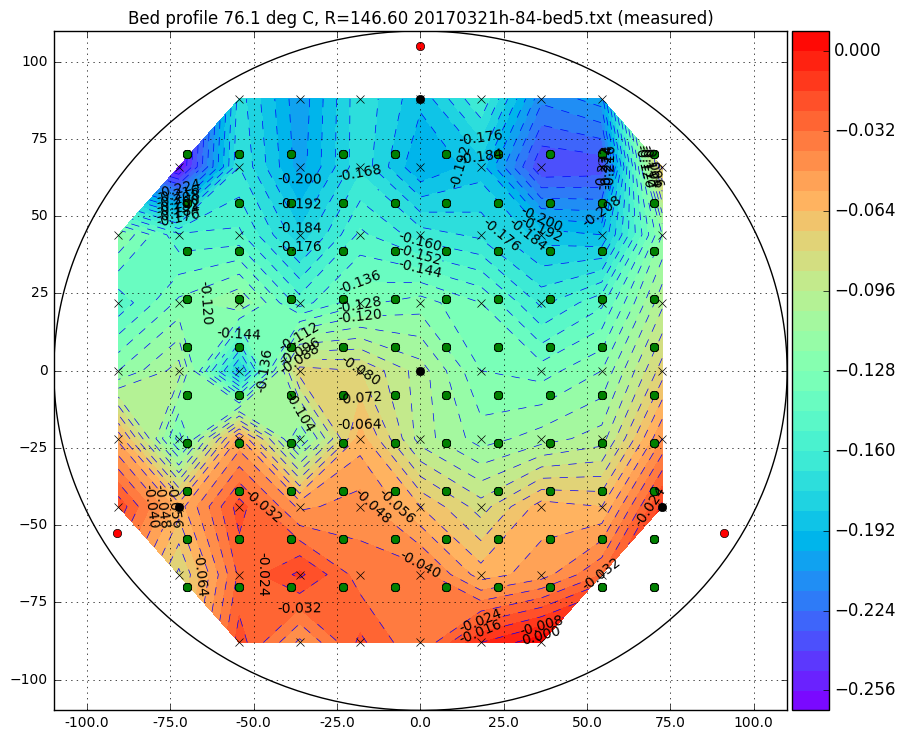

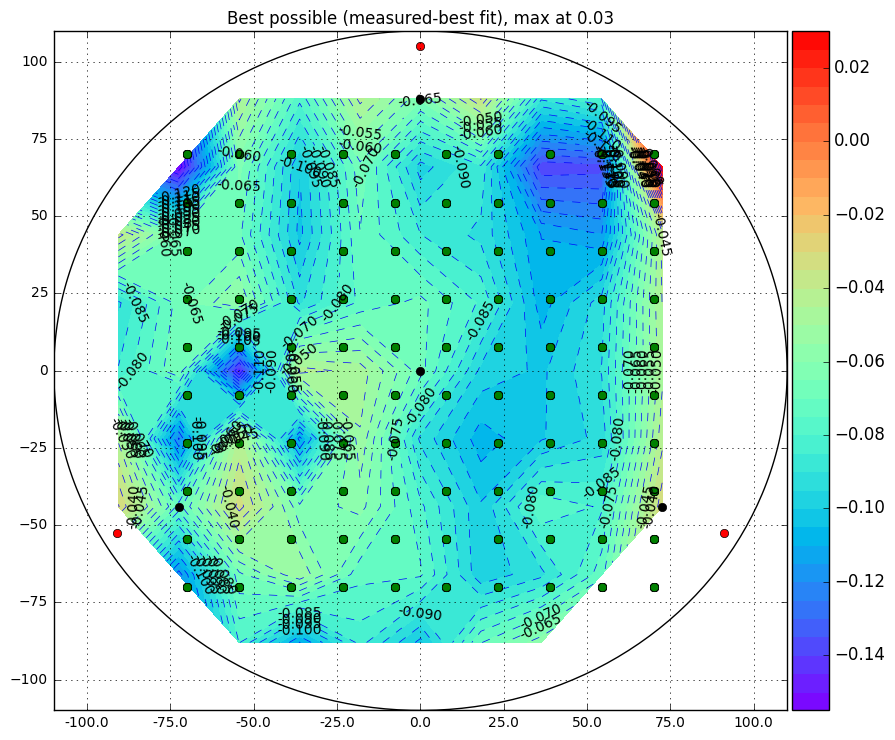

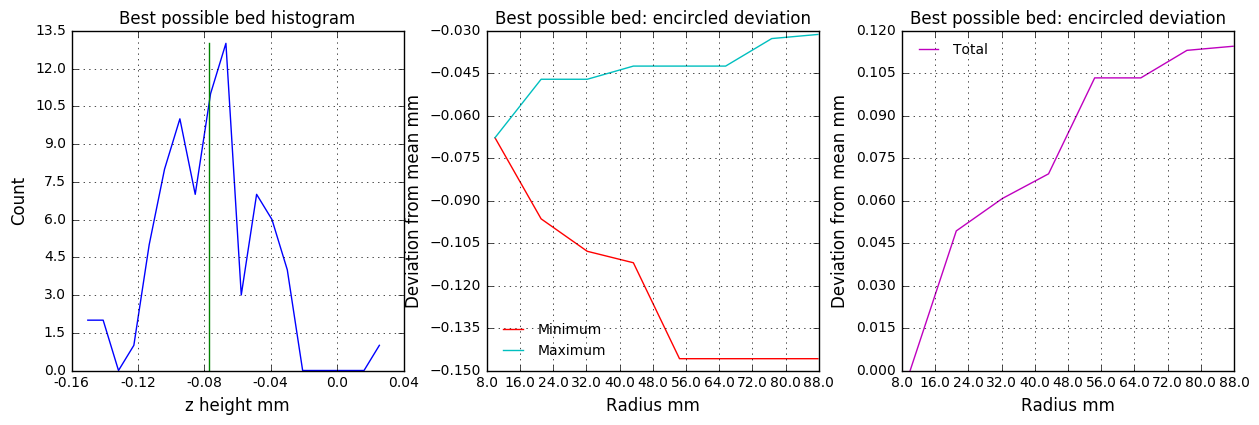

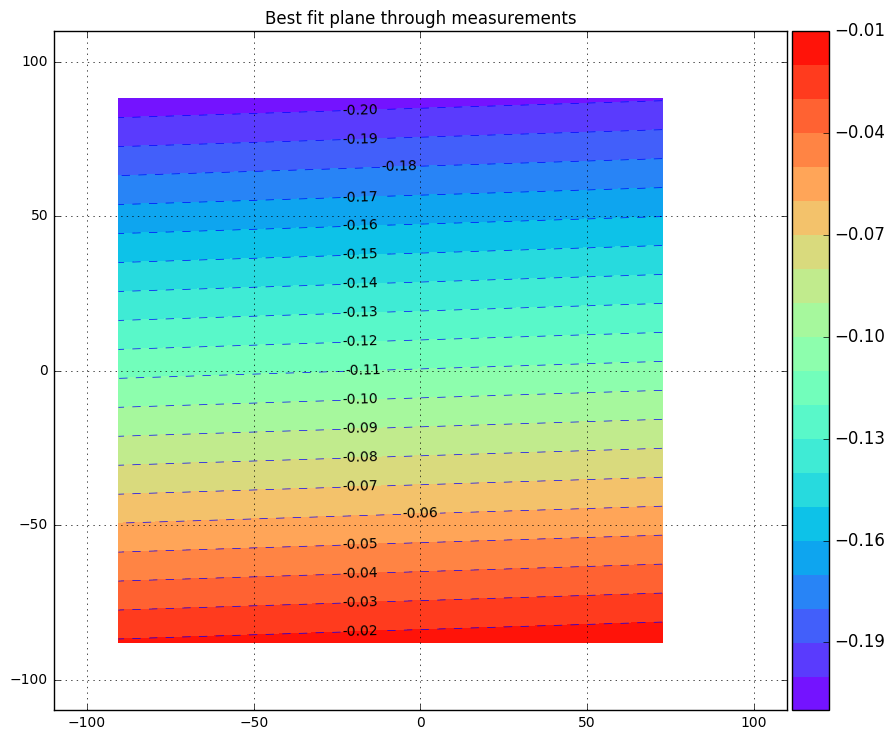

In [200]:
##
def highDensityBed(filename,zProbeOffset=0.,bedRadius=110.,bedlift=0.):
                    
    df, drad, zProbeOffset,bedtemp,mtime,nozztemp = \
            readInputFile(filename) 
        
    # the g30 command already corrected for the x,y offset
    # correct for probe offset to get to metal
    df['z'] = df['z'] - zProbeOffset
    # remove all samples at extreme x, measurement not reliable
    df = df[df['x']<=75]
    # group measurements at each x,y by taking mean of z
    dfr = df.groupby(by=['x','y']).aggregate(np.mean).reset_index().sort_values(by=['x','y'])
    # pivot to get x,y table format
    dfp = dfr.pivot(index='y', columns='x', values='z')

    # get the statistical best fit, this is best 'level' condition
    xUm,yUm,bfcorrected,bfcoeff,bfplane = getBestFitPlane(dfp,dfr,lift=bedlift)
     
    # now get the max variation within circles around centre
    tradiuss,minIntradius,maxIntradius = variationInCircles(xUm,yUm,bfcorrected)
    
    val,bins,dfpflat = getZCorrectedHistogram(bfcorrected)

    dfptwr = getZCorrectedMeasurementPoints(dfp,bfcorrected)

    print('Time {} '.format(mtime))
    print('Bed temperature is {} deg C'.format(bedtemp))
    print('Nozzle temperature is {} deg C'.format(nozztemp))
    print('M851 zProbeOffset is Z{} mm'.format(zProbeOffset))
    print('\nMeasured bed statistics: min={:.3f}  mean={:.3f}  max={:.3f} stddev={:.3f} spread={:.3f}'.format(
            np.nanmin(dfp),np.nanmean(dfp), np.nanmax(dfp), np.nanstd(dfp),
            np.nanmax(dfp)-np.nanmin(dfp)))
    print('Full measured bed:')
    print(dfp)
    print('\nBest fit bed:')
    print('Best fit plane coefficients {}'.format(bfcoeff))
    print('Best fit corrected bed statistics: min={:.3f}  mean={:.3f}  max={:.3f} stddev={:.3f} spread={:.3f}\n'.format(
            np.nanmin(dfpflat),np.nanmean(dfpflat), np.nanmax(dfpflat), np.nanstd(dfpflat),
            np.nanmax(dfpflat)-np.nanmin(dfpflat)))
    if True:
        print('Corrected bed:')
        print(bfcorrected)
    print('\nCorrected bed height at probing points: full bed at/below zero:')
    print(dfptwr)

    if showMarlinSamples:
        # Marlin auto-level probing positions
        DELTA_PRINTABLE_RADIUS = 110.0    
        DELTA_PROBEABLE_RADIUS = DELTA_PRINTABLE_RADIUS - 40.
        LEFT_PROBE_BED_POSITION  = -(DELTA_PROBEABLE_RADIUS)
        AUTO_BED_LEVELING_GRID_POINTS = 10
        mX = np.linspace(-LEFT_PROBE_BED_POSITION, LEFT_PROBE_BED_POSITION, AUTO_BED_LEVELING_GRID_POINTS)
        mY = np.linspace(-LEFT_PROBE_BED_POSITION, LEFT_PROBE_BED_POSITION, AUTO_BED_LEVELING_GRID_POINTS)
        marX, marY = np.meshgrid(mX,mY)
        
    # create circles for plotting below
    rang = np.linspace(0,2*np.pi,360)
    xb = bedRadius * np.sin(rang)
    yb = bedRadius * np.cos(rang)

    # here are the points used  
    calibsamples = np.asarray([[0,0],[-72.5,-44],[72.5,-44],[0,88]])
    screws = np.asarray([[0,105.],[-105*np.cos(np.pi/6.),-105*np.sin(np.pi/6.)],
                         [105*np.cos(np.pi/6.),-105*np.sin(np.pi/6.)]])
    
    # measured data
    p = ryplot.Plotter(1,1,1,figsize=(10,9));
    p.meshContour(1,xUm,yUm,dfp,cbarshow=True,drawGrid=True,contFmt='%.3f',
                  levels=40,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Bed profile {} deg C, R={} {} (measured)'.format(bedtemp,drad,filename));

    p.plot(1,xb,yb,plotCol=['k']);
    p.plot(1,dfr['x'],dfr['y'],markers=['x'],linestyle='',plotCol=['k'],linewidths=[1]);
    p.plot(1,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
    p.plot(1,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);
    if showMarlinSamples:
        p.plot(1,marX,marY,markers=['o'],linestyle='',plotCol=['g']);

    
    if False:
        #interpolate for plotting
        xi=xUm.ravel()              #Flat input into 1d vector
        xi=list(xi[xi!=np.isnan])   #eliminate any NaN
        yi=yUm.ravel()
        yi=list(yi[yi!=np.isnan])
        zi=dfp.values.ravel()
        zi=list(zi[zi!=np.isnan])
        from scipy.interpolate import griddata
        numinterp = 100
        xnew = np.linspace(-110.,110.,numinterp)
        ynew = np.linspace(-110.,110.,numinterp)
        znew = griddata((xi, yi), zi, (xnew[None,:], ynew[:,None]), method='linear')

        q = ryplot.Plotter(2,1,1,figsize=(10,9));
        q.meshContour(1,xnew,ynew,znew,cbarshow=True,drawGrid=True,
                      levels=40,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                      ptitle='Bed profile {} deg C, R={} {} (interpolated)'.format(bedtemp,drad,filename));

        q.plot(1,xb,yb,plotCol=['k']);
        q.plot(1,dfr['x'],dfr['y'],markers=['x'],linestyle='',plotCol=['k'],linewidths=[1]);
        q.plot(1,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
        q.plot(1,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);

        
        
    r = ryplot.Plotter(3,1,1,figsize=(10,9));
    r.meshContour(1,xUm,yUm,bfcorrected.values,cbarshow=True,drawGrid=True,contFmt='%.3f',
                  levels=40,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Best possible (measured-best fit), max at {}'.format(bedlift));
    r.plot(1,xb,yb,plotCol=['k']);
    r.plot(1,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
    r.plot(1,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);
    if showMarlinSamples:
        r.plot(1,marX,marY,markers=['o'],linestyle='',plotCol=['g']);

    s = ryplot.Plotter(4,1,3,figsize=(15,4.5))
    s.plot(1,(bins[:-1]+bins[1:])/2., val)
    s.plot(1,np.asarray([np.nanmean(dfpflat),np.nanmean(dfpflat)]),np.asarray([0,np.max(val)]),
          'Best possible bed histogram','z height mm','Count',maxNX=5)
    s.plot(2,tradiuss,minIntradius,label=['Minimum'])
    s.plot(2,tradiuss,maxIntradius,'Best possible bed: encircled deviation','Radius mm','Deviation from mean mm',label=['Maximum'])
    s.plot(3,tradiuss,maxIntradius-minIntradius,'Best possible bed: encircled deviation','Radius mm','Deviation from mean mm',label=['Total'])

    if True:
        # best fit plane corrected
        t = ryplot.Plotter(5,1,1,figsize=(10,9))
        t.meshContour(1,xUm,yUm,bfplane,cbarshow=True,drawGrid=True,
                      levels=20,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                      ptitle='Best fit plane through measurements');


# highDensityBed('20170313c-84-bed1.txt')
highDensityBed('20170321h-84-bed5.txt',bedlift=0.03)


## Sanding the bed

The bed was initially very uneven, with peaks and valleys ranging over almost 0.6 mm.  The peaks in particular were small and high - not something that the Marlin mesh levelling algorithm can handle.  In fact, I tried to use the mesh bed levelling and the resulting bed correction was not sufficient to print a first layer of 0.2 (which was my objective).  It was possible to print small objects near the centre of the bed, but anything larger than 50 mm radius did not even print with a first later thickness of 0.3.  So for all practical purposes the bed was unusable.  A trip to a local 3D printer store and a crude inspection with straight edge indicated that the bed offered to me was not really flat either. So I decided to sand the bed.

The bed is anodised when delivered, so sanding requires removing some or all of the anodising.  Anodising is about four times harder than untreated aluminium.  The anodising layer thickness is only 10 to 50 microns thick (and coming from a Chinese supplier, it will be on the low side).  The thin layer of anodising protects the surface from light scratches an oxidation.  However, even a 50 um layer will not protect the surface from deep or hard scratches, because the structural support is the softer aluminium beneath. The kind of treatment a print bed experiences classifies as hard scratches and the anodising with not offer much protection here.

There are several possible means to process the surface to make it level:
 
- Milling is probably the best but not possible on an assembled bed.  You also need access to a milling machine.
- Lapping with a rotating table, a second plate, and grit slurry can provide very flat surfaces, but I don't have such equipment.
- Sanding on a flat reference surface (flat glass plate) with slurry or water sand paper. You have a large reference surface that is very flat and you slide the smaller bed over the  surface such that the mountains are sanded away first.  A random or orbittal movement is required.  This approach is feasible for DIY, nbut requires that you remove the bed from the printer. 
- Sanding down the peaks with a sanding block (the larger the better).  This is risky and requires the most time because you must measure the bed profile regularly.  The risk is that the sanding process is the least controlled of all of these and you can easily end up in a cycle of damage control events. 
- Sanding down the peaks by finger on sandpaper. This is the most risky because you can easily sand a small local valley where not intended.  Also sanding a 75 deg C bed by finders is not a nice experience. I did use finger sanding a few times, but with proper care to not overdo it.

At the time I did the work I had no other resources than a rubber sanding block (a harder wood or metal block might have been better?). I decided not to use an orbital sander, because the plate remained in the printer and I did not want to risk potential damage. The orbital sander's base is also very soft and it won't just sand down the valleys. Finally, you don't get tired when you use the orbital sander and can easily overdo it.  So, sanding by hand it was.

I used water sandpaper with grit sizes of 100 for rough work, 180 for smoothing down and cleaning up and 600 for  obtaining a really nice and smooth surface.  The 100-grit is required if you want to remove material, finer grit just takes forever, but the 100-grit leaves the surface in a very rough state. I did not try to print on the 100-grit surface, but suspect that it might not work so well.  The 100-grit paper has particles of the order of [150 um](https://en.wikipedia.org/wiki/Sandpaper), so the damage to the plate is substantial (not quite 150 um, I think). The 180-grit has particle sizes of 80 um, whereas 600-grit paper has particle sizes of 25 um. So, ideally, we don't want to use 100-grit paper because of the damage, but it is the only practical way to removal of substantial material (i.e., 100 um or more) by hand sanding. Note that as the sandpaper is used, it loses its bite and takes off less and less material. So be very careful of fresh 100-grit paper - it is really dangerous. And come near the bed with a file!

This procedure uses the printer's z-probe to measure the bed. The accuracy z-probe measurements depend on the repeatability of the endstop triggers.  Take the time and ensure that the endstop switches are repeatable between subsequent runs.  Do repeated G30 probes to fixed postions on the bed and study the repeatability of the z values returned by the G30.  If you are using the standard Trium end stop switches, you may want to [read this](http://trium3d.proboards.com/thread/112/solution-mechanical-end-stop-repeatability).

I choose to do the measurements with a hot bed, because first layer prints will normally be done on a hot bed.

Here is the very simple procedure:

- Remove all anodising to provide a common metal baseline to the inductive z-probe measurement.
- Heat up the bed to working temperature (75 deg C in my case).
- Measure the bed profile with the 84 sample gcode and plot the results (as shown above).
- Study the 'best fit corrected' bed profile because that shows deviation from nominal level. Identity the mountains and peaks for removal, but also carefully study the valleys that you should avoid.
- Finger sand down the small and high peaks. Mark them beforehand on the bed so that you know where to sand.
- Use the sanding block to remove large areas of high-lying bed.
- Start with 100-grit sandpaper and remove material. Clean up the metal dust frequenty (it is best to the sanding with a vacuum running to remove the dust).
- Do a measurement again and repeat the process until you are satisfied with the results. Don't bother with 180-grit paper at this stage.   This can take many repeats - I did at least 10 to 15 repeats to get to an acceptable bed. And even then it was not so nice, printing on glass will be easier.
- Do a clean up with 180-grit sandpaper
- Do a final smoothing with 600-grit or 1200-grit sandpaper.



